# Interactive Global Trade Simulation

This notebook provides an interactive interface to simulate global trade dynamics with adjustable parameters:

- **Number of countries**: Customize the scale of the simulation
- **Tariff policies**: Test different trade policies and their effects
- **Friendship thresholds**: Adjust relationship dynamics between countries
- **Connection probability**: Change the initial network density

The simulation includes analytics to determine if the world economy is unipolar (dominated by one country/bloc) or multipolar (balanced between multiple power centers).

# Add logic that it's expensive to ship to farther countries and that landlocked countries have higher transaction costs.

Maybe also add govt/ politics as an constant factor

# Global Trade Network Simulation

This notebook simulates international trade relationships between countries as a dynamic network. The simulation models:

- **Friendship relationships** between countries (ranging from 0 to 1)
- **Tariffs** applied to trade between countries (inversely related to friendship)
- **Transaction costs** for trade between countries

The simulation demonstrates how trade relationships evolve over time based on interaction patterns, showing the emergence of trade communities and the effects of economic policies.

In [13]:
# Import libraries for interactive widgets
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
import seaborn as sns

# For community detection
try:
    from community import community_louvain
except ImportError:
    print("Installing community detection package...")
    !pip install python-louvain
    try:
        from community import community_louvain
    except ImportError:
        print("Could not import community_louvain - community detection functionality will be limited")

# Initialize the global trade network
np.random.seed(42)  # For reproducibility
num_countries = 193
countries = [f"Country_{i}" for i in range(num_countries)]

# Create a directed graph to represent trade relationships
G = nx.DiGraph()
G.add_nodes_from(countries)

# Initialize random friendship strengths (0-1) between countries
friendship_matrix = np.random.random((num_countries, num_countries)) * 0.5 + 0.5  # Values between 0.5 and 1
friendship_threshold = 0.2  # Below this, trade relationship breaks

# Make friendship symmetric and set diagonal to 1 (self-friendship)
friendship_matrix = (friendship_matrix + friendship_matrix.T) / 2
np.fill_diagonal(friendship_matrix, 1.0)

# Initial trade connections - not all countries have direct trade
connection_probability = 0.05  # Sparse initial connections
for i in range(num_countries):
    for j in range(num_countries):
        if i != j and np.random.random() < connection_probability:
            # Add edge with base transaction cost and tariff based on friendship
            tariff = 1.0 - friendship_matrix[i, j]**2  # Friendship strongly reduces tariff
            
            # Generate a random distance factor (representing geographic distance)
            distance = np.random.random() * 10  # Random distance between 0-10 units
            
            # Add edge with all attributes
            G.add_edge(countries[i], countries[j], 
                      friendship=friendship_matrix[i, j],
                      tariff=tariff,
                      distance=distance,
                      transaction_cost=0.05 + 0.1 * np.random.random())  # Base transaction cost

# Function to update the network for each simulation step
def update_network(G, friendship_matrix, step):
    # 1. Trade affects friendship
    for u, v, data in list(G.edges(data=True)):
        i = countries.index(u)
        j = countries.index(v)
        
        # Tariffs reduce friendship
        friendship_matrix[i, j] -= data['tariff'] * 0.01
        friendship_matrix[j, i] = friendship_matrix[i, j]  # Keep symmetric
        
        # Update friendship in the graph
        data['friendship'] = friendship_matrix[i, j]
        
        # Update tariff based on new friendship
        data['tariff'] = 1.0 - friendship_matrix[i, j]**2
        
        # Remove edge if friendship falls below threshold
        if friendship_matrix[i, j] < friendship_threshold:
            G.remove_edge(u, v)
    
    # 2. Random new trade connections emerge
    if step % 5 == 0:  # Every 5 steps
        for _ in range(int(num_countries * 0.02)):  # 2% of countries form new connections
            i = np.random.randint(0, num_countries)
            j = np.random.randint(0, num_countries)
            if i != j and not G.has_edge(countries[i], countries[j]):
                # New trade relationship based on current friendship
                tariff = 1.0 - friendship_matrix[i, j]**2
                distance = np.random.random() * 10  # Random distance between 0-10 units
                G.add_edge(countries[i], countries[j],
                          friendship=friendship_matrix[i, j],
                          tariff=tariff,
                          distance=distance,
                          transaction_cost=0.05 + 0.1 * np.random.random())
    
    # 3. Ensure friendship stays in valid range [0,1]
    friendship_matrix = np.clip(friendship_matrix, 0, 1)
    
    return G, friendship_matrix

# Function to visualize the network
def plot_network(G):
    plt.figure(figsize=(12, 10))
    
    # Use friendship as edge weight for visualization
    edge_weights = [G[u][v]['friendship']*3 for u, v in G.edges()]
    
    # Color edges based on tariffs (red=high tariff, green=low tariff)
    edge_colors = [plt.cm.RdYlGn(1-G[u][v]['tariff']) for u, v in G.edges()]
    
    # Layout with weighted edges
    pos = nx.spring_layout(G, weight='friendship', k=0.2, seed=42)  # Add seed for reproducibility
    
    # Draw the network
    nx.draw_networkx_nodes(G, pos, node_size=30, alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color=edge_colors, 
                          arrowsize=5, connectionstyle="arc3,rad=0.1")
    
    plt.title(f"Global Trade Network - {G.number_of_edges()} trade relationships")
    plt.axis('off')
    plt.tight_layout()
    
    return plt.gcf()

# Simulation function for animation
def simulate(num_steps=100):
    global G, friendship_matrix
    
    stats = {
        'steps': [],
        'num_edges': [],
        'avg_friendship': [],
        'avg_tariff': []
    }
    
    for step in range(num_steps):
        G, friendship_matrix = update_network(G, friendship_matrix, step)
        
        # Collect statistics
        if step % 5 == 0:
            stats['steps'].append(step)
            stats['num_edges'].append(G.number_of_edges())
            
            if G.number_of_edges() > 0:
                avg_friendship = np.mean([G[u][v]['friendship'] for u, v in G.edges()])
                avg_tariff = np.mean([G[u][v]['tariff'] for u, v in G.edges()])
                stats['avg_friendship'].append(avg_friendship)
                stats['avg_tariff'].append(avg_tariff)
            else:
                stats['avg_friendship'].append(0)
                stats['avg_tariff'].append(0)
    
    return stats

# Interactive parameters UI
def create_simulation_ui():
    # Define widgets for simulation parameters
    num_countries_slider = widgets.IntSlider(
        value=50,
        min=10,
        max=200,
        step=5,
        description='Countries:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )
    
    friendship_threshold_slider = widgets.FloatSlider(
        value=0.2,
        min=0.05,
        max=0.5,
        step=0.05,
        description='Friendship Threshold:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )
    
    connection_probability_slider = widgets.FloatSlider(
        value=0.05,
        min=0.01,
        max=0.2,
        step=0.01,
        description='Initial Connection Probability:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )
    
    num_steps_slider = widgets.IntSlider(
        value=100,
        min=20,
        max=500,
        step=20,
        description='Simulation Steps:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )
    
    # Tariff policy dropdown
    tariff_policy = widgets.Dropdown(
        options=[
            ('Friendship-based (Default)', 'default'),
            ('High Tariffs for All', 'high'),
            ('Low Tariffs for All', 'low'),
            ('Random Tariffs', 'random'),
            ('Bloc-based Tariffs', 'bloc')
        ],
        value='default',
        description='Tariff Policy:',
        style={'description_width': 'initial'}
    )
    
    # Country to apply special tariff policy to
    special_tariff_country = widgets.IntText(
        value=0,
        description='Special Tariff Country ID:',
        style={'description_width': 'initial'}
    )
    
    special_tariff_value = widgets.FloatSlider(
        value=0.5,
        min=0.0,
        max=1.0,
        step=0.1,
        description='Special Tariff Value:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )
    
    # Apply button
    apply_button = widgets.Button(
        description='Run Simulation',
        button_style='success',
        tooltip='Click to run the simulation with these parameters'
    )
    
    # Output widget for displaying results
    output = widgets.Output()
    
    # Group related controls
    basic_params = widgets.VBox([
        widgets.HTML(value="<b>Basic Parameters</b>"),
        num_countries_slider,
        friendship_threshold_slider,
        connection_probability_slider,
        num_steps_slider
    ])
    
    tariff_params = widgets.VBox([
        widgets.HTML(value="<b>Tariff Policies</b>"),
        tariff_policy,
        special_tariff_country,
        special_tariff_value
    ])
    
    # Arrange widgets in tabs
    tab = widgets.Tab()
    tab.children = [basic_params, tariff_params]
    tab.set_title(0, 'Basic Parameters')
    tab.set_title(1, 'Tariff Policies')
    
    # Main UI layout
    ui = widgets.VBox([
        tab,
        apply_button,
        output
    ])
    
    # Return all widgets for later access
    params = {
        'num_countries': num_countries_slider,
        'friendship_threshold': friendship_threshold_slider,
        'connection_probability': connection_probability_slider,
        'num_steps': num_steps_slider,
        'tariff_policy': tariff_policy,
        'special_tariff_country': special_tariff_country,
        'special_tariff_value': special_tariff_value,
        'apply_button': apply_button,
        'output': output
    }
    
    return ui, params

In [ ]:
# Display the UI
ui, params = create_simulation_ui()
display(ui)

# Function to initialize the simulation with the given parameters
def initialize_simulation(num_countries, friendship_threshold, connection_probability, 
                         tariff_policy='default', special_country=None, special_tariff=None):
    # Create a directed graph to represent trade relationships
    G = nx.DiGraph()
    
    # Create country nodes
    countries = [f"Country_{i}" for i in range(num_countries)]
    G.add_nodes_from(countries)
    
    # Initialize random friendship strengths (0-1) between countries
    friendship_matrix = np.random.random((num_countries, num_countries)) * 0.5 + 0.5  # Values between 0.5 and 1
    
    # Make friendship symmetric and set diagonal to 1 (self-friendship)
    friendship_matrix = (friendship_matrix + friendship_matrix.T) / 2
    np.fill_diagonal(friendship_matrix, 1.0)
    
    # Initial trade connections - not all countries have direct trade
    for i in range(num_countries):
        for j in range(num_countries):
            if i != j and np.random.random() < connection_probability:
                # Distance factor representing geographic distance
                distance = np.random.random() * 10  # Random distance between 0-10 units
                
                # Set tariff based on the selected policy
                if tariff_policy == 'default':
                    # Default: Friendship-based tariffs
                    tariff = 1.0 - friendship_matrix[i, j]**2
                elif tariff_policy == 'high':
                    # High tariffs for all
                    tariff = 0.7 + 0.3 * np.random.random()
                elif tariff_policy == 'low':
                    # Low tariffs for all
                    tariff = 0.3 * np.random.random()
                elif tariff_policy == 'random':
                    # Random tariffs
                    tariff = np.random.random()
                elif tariff_policy == 'bloc':
                    # Bloc-based tariffs (countries in "regions" have lower tariffs)
                    region_i = i % 5  # Assume 5 distinct regions
                    region_j = j % 5
                    if region_i == region_j:  # Same region
                        tariff = 0.2 * np.random.random()
                    else:  # Different regions
                        tariff = 0.5 + 0.5 * np.random.random()
                
                # Apply special tariff if applicable
                if special_country is not None and special_tariff is not None:
                    if i == special_country:
                        tariff = special_tariff
                
                # Calculate transaction cost based on distance
                transaction_cost = 0.05 + 0.1 * np.random.random() + distance * 0.01
                
                # Add edge with all attributes
                G.add_edge(countries[i], countries[j], 
                          friendship=friendship_matrix[i, j],
                          tariff=tariff,
                          distance=distance,
                          transaction_cost=transaction_cost)
    
    return G, friendship_matrix, countries

# Enhanced simulation function with new parameters
def simulate_with_params(G, friendship_matrix, countries, num_steps=100, friendship_threshold=0.2):
    stats = {
        'steps': [],
        'num_edges': [],
        'avg_friendship': [],
        'avg_tariff': [],
        'num_communities': [],
        'largest_community_size': [],
        'polarity_index': []  # New metric for uni/multipolar analysis
    }
    
    for step in range(num_steps):
        # 1. Trade affects friendship
        for u, v, data in list(G.edges(data=True)):
            i = countries.index(u)
            j = countries.index(v)
            
            # Tariffs reduce friendship
            friendship_matrix[i, j] -= data['tariff'] * 0.01
            friendship_matrix[j, i] = friendship_matrix[i, j]  # Keep symmetric
            
            # Update friendship in the graph
            data['friendship'] = friendship_matrix[i, j]
            
            # Update tariff based on new friendship
            data['tariff'] = 1.0 - friendship_matrix[i, j]**2
            
            # Remove edge if friendship falls below threshold
            if friendship_matrix[i, j] < friendship_threshold:
                G.remove_edge(u, v)
        
        # 2. Random new trade connections emerge
        if step % 5 == 0:  # Every 5 steps
            for _ in range(int(len(countries) * 0.02)):  # 2% of countries form new connections
                i = np.random.randint(0, len(countries))
                j = np.random.randint(0, len(countries))
                if i != j and not G.has_edge(countries[i], countries[j]):
                    # New trade relationship based on current friendship
                    tariff = 1.0 - friendship_matrix[i, j]**2
                    distance = np.random.random() * 10
                    G.add_edge(countries[i], countries[j],
                              friendship=friendship_matrix[i, j],
                              tariff=tariff,
                              distance=distance,
                              transaction_cost=0.05 + 0.1 * np.random.random() + distance * 0.01)
        
        # 3. Ensure friendship stays in valid range [0,1]
        friendship_matrix = np.clip(friendship_matrix, 0, 1)
        
        # Collect statistics 
        if step % 5 == 0:
            stats['steps'].append(step)
            stats['num_edges'].append(G.number_of_edges())
            
            if G.number_of_edges() > 0:
                avg_friendship = np.mean([G[u][v]['friendship'] for u, v in G.edges()])
                avg_tariff = np.mean([G[u][v]['tariff'] for u, v in G.edges()])
                stats['avg_friendship'].append(avg_friendship)
                stats['avg_tariff'].append(avg_tariff)
                
                # Analyze communities if there are edges
                if G.number_of_edges() > 10:  # Need minimum edges for meaningful community detection
                    G_undir = G.to_undirected()
                    try:
                        # Detect communities using Louvain method
                        partition = community_louvain.best_partition(G_undir)
                        communities = set(partition.values())
                        num_communities = len(communities)
                        
                        # Count community sizes
                        community_sizes = {}
                        for com in communities:
                            size = sum(1 for node in partition if partition[node] == com)
                            community_sizes[com] = size
                        
                        largest_community_size = max(community_sizes.values())
                        
                        # Calculate polarity index (ratio of largest community to total nodes)
                        polarity_index = largest_community_size / len(countries)
                        
                        stats['num_communities'].append(num_communities)
                        stats['largest_community_size'].append(largest_community_size)
                        stats['polarity_index'].append(polarity_index)
                    except:
                        # Fallback if community detection fails
                        stats['num_communities'].append(0)
                        stats['largest_community_size'].append(0)
                        stats['polarity_index'].append(0)
                else:
                    stats['num_communities'].append(0)
                    stats['largest_community_size'].append(0)
                    stats['polarity_index'].append(0)
            else:
                stats['avg_friendship'].append(0)
                stats['avg_tariff'].append(0)
                stats['num_communities'].append(0)
                stats['largest_community_size'].append(0)
                stats['polarity_index'].append(0)
    
    return G, friendship_matrix, stats

# Function to analyze if the economy is unipolar or multipolar
def analyze_polarity(stats):
    # Higher polarity index indicates more unipolar economy
    # Lower polarity index indicates more multipolar economy
    
    if not stats['polarity_index'] or max(stats['polarity_index']) == 0:
        return "Unable to determine polarity due to insufficient data"
    
    final_polarity = stats['polarity_index'][-1]
    
    if final_polarity > 0.5:
        polarity_type = "Strongly Unipolar"
    elif final_polarity > 0.3:
        polarity_type = "Moderately Unipolar"
    elif final_polarity > 0.2:
        polarity_type = "Balanced/Transitional"
    else:
        polarity_type = "Multipolar"
    
    return polarity_type

# Function to visualize the impact of tariffs
def visualize_tariff_impact(G, countries, special_country_id=None):
    if special_country_id is not None and special_country_id < len(countries):
        special_country = countries[special_country_id]
        
        # Get incoming and outgoing connections for the special country
        if G.has_node(special_country):
            # Calculate trade metrics
            incoming_edges = list(G.in_edges(special_country, data=True))
            outgoing_edges = list(G.out_edges(special_country, data=True))
            
            # Create dataframes for analysis
            incoming_data = []
            for u, v, data in incoming_edges:
                incoming_data.append({
                    'From': u, 
                    'Tariff': data['tariff'],
                    'Transaction Cost': data['transaction_cost'],
                    'Friendship': data['friendship']
                })
            
            outgoing_data = []
            for u, v, data in outgoing_edges:
                outgoing_data.append({
                    'To': v, 
                    'Tariff': data['tariff'],
                    'Transaction Cost': data['transaction_cost'],
                    'Friendship': data['friendship']
                })
            
            # Visualize the impact
            plt.figure(figsize=(14, 10))
            plt.suptitle(f'Tariff Impact Analysis for {special_country}', fontsize=16)
            
            # If we have incoming trade
            if incoming_data:
                df_in = pd.DataFrame(incoming_data)
                ax1 = plt.subplot(2, 2, 1)
                df_in = df_in.sort_values('Tariff')
                sns.barplot(x='Tariff', y='From', data=df_in, ax=ax1)
                ax1.set_title(f'Incoming Tariffs to {special_country}')
                
                ax2 = plt.subplot(2, 2, 2)
                sns.scatterplot(x='Tariff', y='Friendship', data=df_in, ax=ax2)
                sns.regplot(x='Tariff', y='Friendship', data=df_in, ax=ax2, scatter=False, color='red')
                ax2.set_title('Incoming Trade: Tariff vs Friendship')
            
            # If we have outgoing trade
            if outgoing_data:
                df_out = pd.DataFrame(outgoing_data)
                ax3 = plt.subplot(2, 2, 3)
                df_out = df_out.sort_values('Tariff')
                sns.barplot(x='Tariff', y='To', data=df_out, ax=ax3)
                ax3.set_title(f'Outgoing Tariffs from {special_country}')
                
                ax4 = plt.subplot(2, 2, 4)
                sns.scatterplot(x='Tariff', y='Friendship', data=df_out, ax=ax4)
                sns.regplot(x='Tariff', y='Friendship', data=df_out, ax=ax4, scatter=False, color='red')
                ax4.set_title('Outgoing Trade: Tariff vs Friendship')
            
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()
            
            # Display summary statistics
            print(f"\nTrade Summary for {special_country}:")
            print(f"- Incoming trade connections: {len(incoming_edges)}")
            print(f"- Outgoing trade connections: {len(outgoing_edges)}")
            
            if incoming_data:
                avg_in_tariff = np.mean([d['Tariff'] for d in incoming_data])
                print(f"- Average incoming tariff: {avg_in_tariff:.4f}")
            
            if outgoing_data:
                avg_out_tariff = np.mean([d['Tariff'] for d in outgoing_data])
                print(f"- Average outgoing tariff: {avg_out_tariff:.4f}")
        else:
            print(f"{special_country} is not participating in trade.")
    else:
        print("Please specify a valid country ID for tariff impact analysis.")

In [16]:
# New enhanced visualization function for the parameterized simulation
def run_interactive_simulation(G, friendship_matrix, countries, stats, special_country_id=None):
    # Create a figure with proper spacing
    fig = plt.figure(figsize=(16, 18))
    fig.suptitle('Global Trade Network Simulation Results', fontsize=16)
    
    # Plot 1: Network visualization
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    
    # Use friendship as edge weight for visualization
    edge_weights = [G[u][v]['friendship']*3 for u, v in G.edges()]
    
    # Color edges based on tariffs (red=high tariff, green=low tariff)
    edge_colors = [plt.cm.RdYlGn(1-G[u][v]['tariff']) for u, v in G.edges()]
    
    # Layout with weighted edges
    pos = nx.spring_layout(G, weight='friendship', k=0.2, seed=42)
    
    # Draw the network
    nx.draw_networkx_nodes(G, pos, node_size=30, alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color=edge_colors, 
                          arrowsize=5, connectionstyle="arc3,rad=0.1")
    
    # Highlight special country if specified
    if special_country_id is not None and special_country_id < len(countries):
        special_country = countries[special_country_id]
        if G.has_node(special_country):
            nx.draw_networkx_nodes(G, pos, nodelist=[special_country], 
                                 node_size=200, node_color='red', alpha=0.8)
            # Add label for special country
            labels = {special_country: special_country}
            nx.draw_networkx_labels(G, pos, labels, font_size=12, font_color='black')
    
    ax1.set_title(f"Global Trade Network - {G.number_of_edges()} trade relationships")
    ax1.axis('off')
    
    # Plot 2: Trade relationships over time
    ax2 = plt.subplot2grid((3, 2), (1, 0))
    ax2.plot(stats['steps'], stats['num_edges'], 'b-', linewidth=2)
    ax2.set_title('Number of Trade Relationships')
    ax2.set_xlabel('Simulation Steps')
    ax2.set_ylabel('Count')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Friendship and tariff over time
    ax3 = plt.subplot2grid((3, 2), (1, 1))
    ax3.plot(stats['steps'], stats['avg_friendship'], 'g-', linewidth=2, label='Avg Friendship')
    ax3.plot(stats['steps'], stats['avg_tariff'], 'r-', linewidth=2, label='Avg Tariff')
    ax3.set_title('Trade Relationship Metrics')
    ax3.set_xlabel('Simulation Steps')
    ax3.set_ylabel('Value')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # Plot 4: Communities and Polarity Index (if available)
    if 'num_communities' in stats and stats['num_communities']:
        ax4 = plt.subplot2grid((3, 2), (2, 0))
        ax4.plot(stats['steps'], stats['num_communities'], 'm-', linewidth=2)
        ax4.set_title('Number of Trade Communities')
        ax4.set_xlabel('Simulation Steps')
        ax4.set_ylabel('Count')
        ax4.grid(True, alpha=0.3)
        
        ax5 = plt.subplot2grid((3, 2), (2, 1))
        ax5.plot(stats['steps'], stats['polarity_index'], 'c-', linewidth=2)
        ax5.set_title('Polarity Index (Higher = More Unipolar)')
        ax5.set_xlabel('Simulation Steps')
        ax5.set_ylabel('Index')
        ax5.grid(True, alpha=0.3)
        
        # Add horizontal lines for polarity thresholds
        ax5.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Strongly Unipolar')
        ax5.axhline(y=0.3, color='y', linestyle='--', alpha=0.5, label='Moderately Unipolar')
        ax5.axhline(y=0.2, color='g', linestyle='--', alpha=0.5, label='Balanced/Transitional')
        ax5.legend(loc='upper right')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
    plt.show()
    
    # Print summary statistics
    if G.number_of_edges() > 0:
        print(f"\nSummary Statistics:")
        print(f"  - Final number of trade relationships: {G.number_of_edges()}")
        print(f"  - Average friendship level: {stats['avg_friendship'][-1]:.4f}")
        print(f"  - Average tariff level: {stats['avg_tariff'][-1]:.4f}")
        
        # Calculate network density
        density = nx.density(G)
        print(f"  - Network density: {density:.4f}")
        
        # Calculate reciprocity (proportion of bilateral trade relationships)
        reciprocity = nx.reciprocity(G)
        print(f"  - Trade reciprocity: {reciprocity:.4f}")
        
        # Polarity analysis
        polarity_type = analyze_polarity(stats)
        print(f"\nEconomic Structure Analysis:")
        print(f"  - World economy type: {polarity_type}")
        
        if 'num_communities' in stats and stats['num_communities'] and stats['num_communities'][-1] > 0:
            print(f"  - Number of trade communities: {stats['num_communities'][-1]}")
            print(f"  - Largest community size: {stats['largest_community_size'][-1]} countries")
            
            # Detailed explanation of polarity
            if polarity_type == "Strongly Unipolar":
                print("\nThis economy is dominated by a single trade bloc that controls")
                print("a majority of global trade. Other countries are economically dependent.")
            elif polarity_type == "Moderately Unipolar":
                print("\nThis economy has one dominant bloc with significant influence,")
                print("but other trade communities maintain some independence.")
            elif polarity_type == "Balanced/Transitional":
                print("\nThis economy has several trade blocs of similar size")
                print("with balanced influence on global trade.")
            elif polarity_type == "Multipolar":
                print("\nThis economy has many independent trade communities")
                print("with distributed economic power across the globe.")
    else:
        print("No trade relationships remain after the simulation.")

# Run the simulation when the button is clicked
def on_apply_button_clicked(b):
    with params['output']:
        clear_output()
        print("Running simulation with parameters:")
        print(f"- Number of countries: {params['num_countries'].value}")
        print(f"- Friendship threshold: {params['friendship_threshold'].value}")
        print(f"- Connection probability: {params['connection_probability'].value}")
        print(f"- Tariff policy: {params['tariff_policy'].value}")
        print(f"- Special tariff country ID: {params['special_tariff_country'].value}")
        print(f"- Special tariff value: {params['special_tariff_value'].value}")
        print(f"- Simulation steps: {params['num_steps'].value}")
        print("Please wait while the simulation runs...\n")
        
        # Initialize the simulation
        special_country = params['special_tariff_country'].value
        special_tariff = params['special_tariff_value'].value
        
        G, friendship_matrix, countries = initialize_simulation(
            params['num_countries'].value,
            params['friendship_threshold'].value,
            params['connection_probability'].value,
            params['tariff_policy'].value,
            special_country,
            special_tariff
        )
        
        # Run the simulation
        G, friendship_matrix, stats = simulate_with_params(
            G, 
            friendship_matrix, 
            countries, 
            params['num_steps'].value,
            params['friendship_threshold'].value
        )
        
        # Visualize the results
        run_interactive_simulation(G, friendship_matrix, countries, stats, special_country)
        
        # Show tariff impact for the special country
        if special_country is not None and special_country < len(countries):
            visualize_tariff_impact(G, countries, special_country)

# Attach the function to the button
params['apply_button'].on_click(on_apply_button_clicked)

## Basic Network Simulation and Visualization

Below, we run a 100-step simulation of the global trade network and visualize the results. The simulation shows:

1. The network graph of trade relationships between countries
2. The evolution of the number of trade relationships over time
3. Changes in average friendship and tariff levels

As the simulation progresses, countries with stronger friendships maintain lower tariffs, while countries with weaker relationships may lose trade connections entirely.

In [7]:
# Run a short simulation and visualize results
def run_and_visualize(num_steps=100):
    stats = simulate(num_steps)
    
    # Create a figure with proper spacing
    fig = plt.figure(figsize=(16, 14))
    fig.suptitle('Global Trade Network Simulation Results', fontsize=16)
    
    # Add subplot for network visualization
    ax1 = fig.add_subplot(2, 1, 1)
    # Get network figure and display in the right subplot
    network_fig = plot_network(G)
    plt.close(network_fig)  # Close the separate figure
    ax1 = plt.subplot(2, 1, 1)
    ax1.set_title(f"Global Trade Network - {G.number_of_edges()} relationships")
    ax1.axis('off')
    
    # Add subplot for edge count over time
    ax2 = fig.add_subplot(2, 2, 3)
    ax2.plot(stats['steps'], stats['num_edges'], 'b-', linewidth=2)
    ax2.set_title('Number of Trade Relationships')
    ax2.set_xlabel('Simulation Steps')
    ax2.set_ylabel('Count')
    ax2.grid(True, alpha=0.3)
    
    # Add subplot for friendship and tariff
    ax3 = fig.add_subplot(2, 2, 4)
    ax3.plot(stats['steps'], stats['avg_friendship'], 'g-', linewidth=2, label='Avg Friendship')
    ax3.plot(stats['steps'], stats['avg_tariff'], 'r-', linewidth=2, label='Avg Tariff')
    ax3.set_title('Trade Relationship Metrics')
    ax3.set_xlabel('Simulation Steps')
    ax3.set_ylabel('Value')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
    plt.show()
    
    # Print summary statistics
    if G.number_of_edges() > 0:
        print(f"\nSummary Statistics after {num_steps} steps:")
        print(f"  - Final number of trade relationships: {G.number_of_edges()}")
        print(f"  - Average friendship level: {stats['avg_friendship'][-1]:.4f}")
        print(f"  - Average tariff level: {stats['avg_tariff'][-1]:.4f}")
        
        # Calculate network density
        density = nx.density(G)
        print(f"  - Network density: {density:.4f}")
        
        # Calculate reciprocity (proportion of bilateral trade relationships)
        reciprocity = nx.reciprocity(G)
        print(f"  - Trade reciprocity: {reciprocity:.4f}")
    else:
        print("No trade relationships remain after the simulation.")

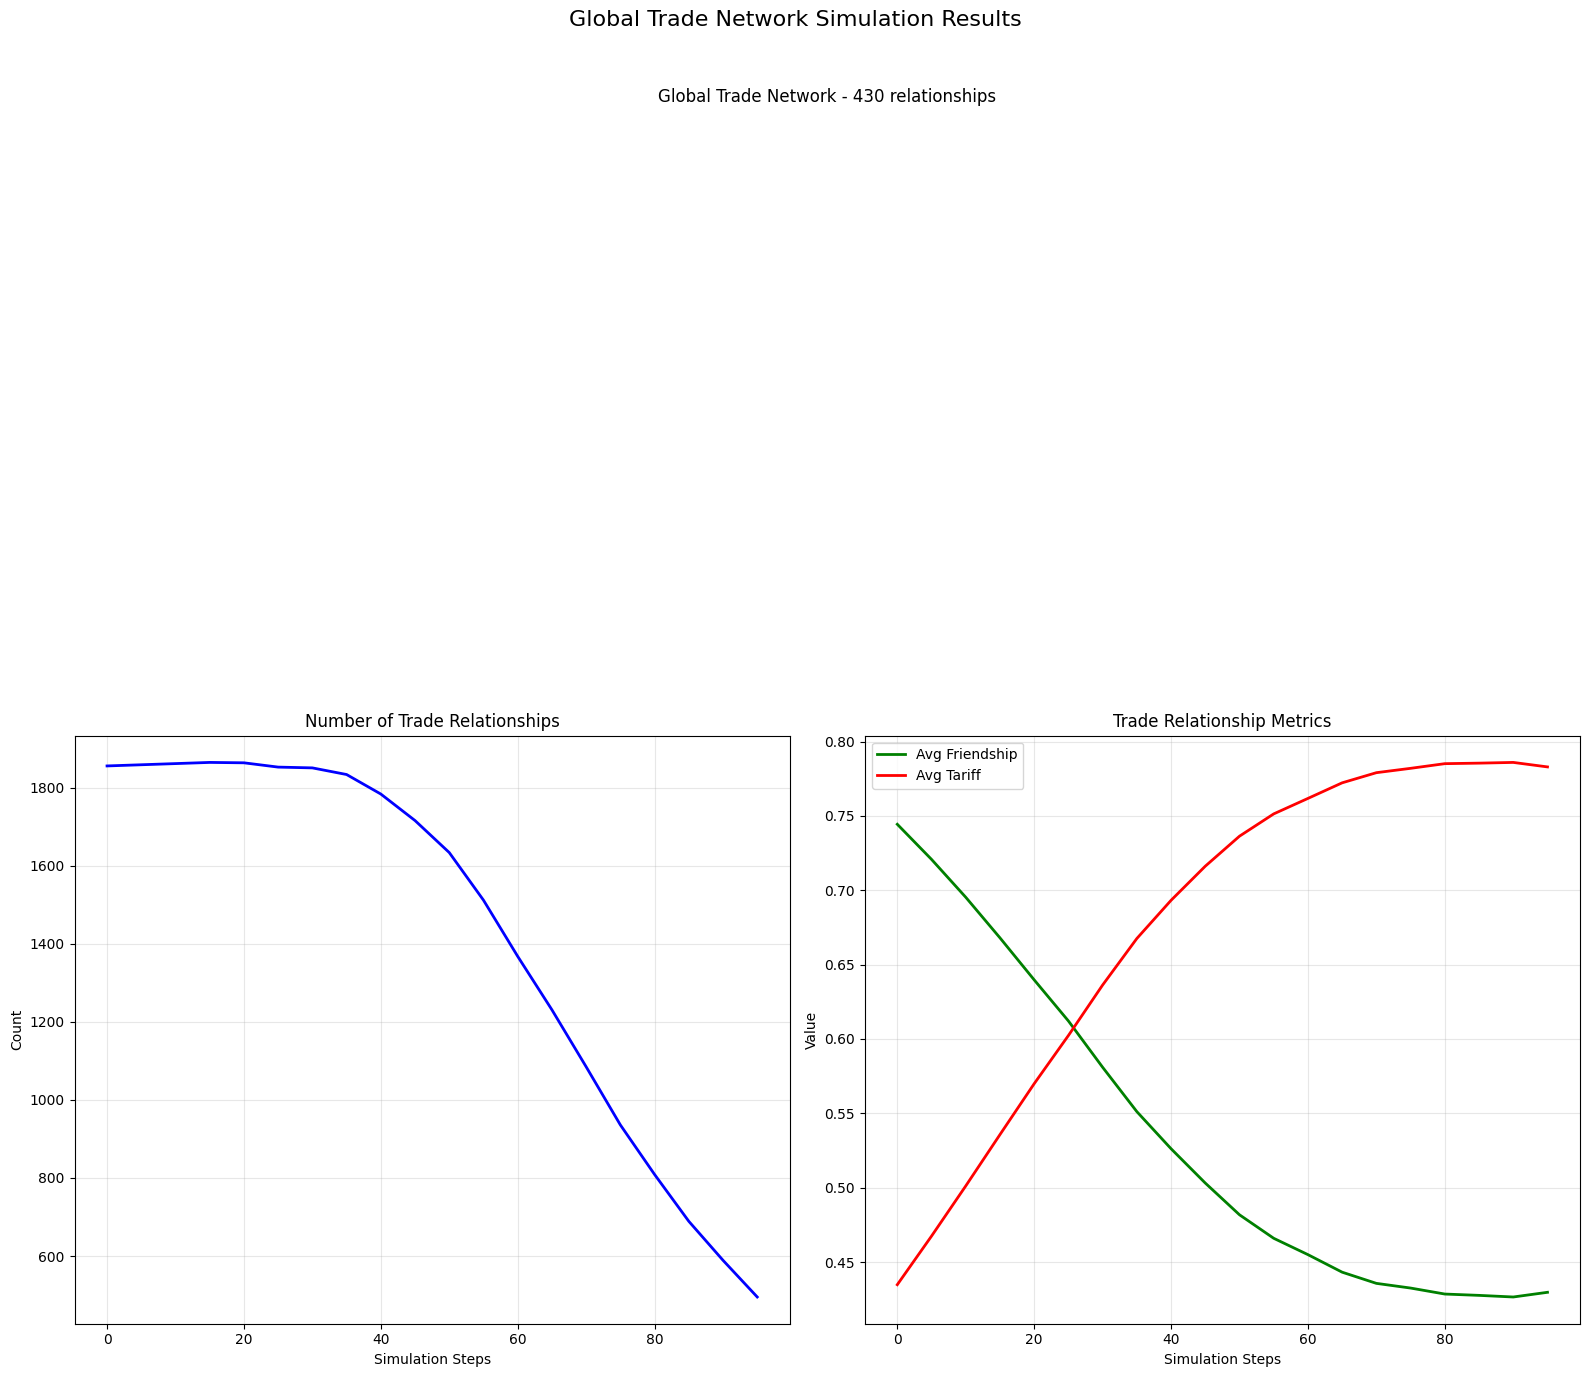


Summary Statistics after 100 steps:
  - Final number of trade relationships: 430
  - Average friendship level: 0.4297
  - Average tariff level: 0.7830
  - Network density: 0.0116
  - Trade reciprocity: 0.0000


In [8]:
run_and_visualize(100)

## Analyzing Geographic Distance Effects

Distance plays a crucial role in international trade. Countries that are geographically closer tend to trade more frequently and with lower transaction costs. In our simulation, we explore the relationship between:

- Geographic distance between countries
- Transaction costs of trade
- Tariff levels

The analysis below shows how distance correlates with these economic factors.

In [9]:
# Analyze the relationship between distance and transaction cost
def analyze_distance_effect():
    if G.number_of_edges() > 0:
        # Safely extract edge attributes
        edges_data = []
        for u, v, data in G.edges(data=True):
            # Check if all required attributes exist
            if all(attr in data for attr in ['distance', 'transaction_cost', 'tariff', 'friendship']):
                edges_data.append({
                    'Distance': data['distance'],
                    'Transaction Cost': data['transaction_cost'],
                    'Tariff': data['tariff'],
                    'Friendship': data['friendship']
                })
        
        # Create DataFrame for analysis
        if edges_data:
            df = pd.DataFrame(edges_data)
            
            # Set up a nice style for the plots
            sns.set_style('whitegrid')
            
            # Create a figure with multiple subplots
            fig = plt.figure(figsize=(16, 12))
            fig.suptitle('Impact of Geographic Distance on Trade Relationships', fontsize=16)
            
            # Plot 1: Distance vs. Transaction Cost
            ax1 = fig.add_subplot(2, 2, 1)
            sns.scatterplot(x='Distance', y='Transaction Cost', data=df, ax=ax1, alpha=0.6)
            sns.regplot(x='Distance', y='Transaction Cost', data=df, ax=ax1, scatter=False, color='red')
            ax1.set_title('Distance vs. Transaction Cost')
            
            # Plot 2: Distance vs. Tariff
            ax2 = fig.add_subplot(2, 2, 2)
            sns.scatterplot(x='Distance', y='Tariff', data=df, ax=ax2, alpha=0.6)
            sns.regplot(x='Distance', y='Tariff', data=df, ax=ax2, scatter=False, color='red')
            ax2.set_title('Distance vs. Tariff')
            
            # Plot 3: Distance vs. Friendship
            ax3 = fig.add_subplot(2, 2, 3)
            sns.scatterplot(x='Distance', y='Friendship', data=df, ax=ax3, alpha=0.6)
            sns.regplot(x='Distance', y='Friendship', data=df, ax=ax3, scatter=False, color='red')
            ax3.set_title('Distance vs. Friendship')
            
            # Plot 4: Transaction Cost vs. Tariff
            ax4 = fig.add_subplot(2, 2, 4)
            sns.scatterplot(x='Transaction Cost', y='Tariff', data=df, ax=ax4, alpha=0.6)
            sns.regplot(x='Transaction Cost', y='Tariff', data=df, ax=ax4, scatter=False, color='red')
            ax4.set_title('Transaction Cost vs. Tariff')
            
            plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
            plt.show()
            
            # Calculate correlations
            print("Correlation Analysis:")
            corr_matrix = df.corr()
            print(corr_matrix.round(4))
            
            # Calculate average transaction costs by distance quartiles
            print("\nTransaction Costs by Distance Quartile:")
            df['Distance Quartile'] = pd.qcut(df['Distance'], 4, labels=['Q1 (Closest)', 'Q2', 'Q3', 'Q4 (Farthest)'])
            quartile_stats = df.groupby('Distance Quartile').agg({
                'Transaction Cost': 'mean',
                'Tariff': 'mean',
                'Friendship': 'mean'
            })
            
            print(quartile_stats.round(4))
        else:
            print("Graph edges don't have the required attributes (distance, transaction_cost, tariff).")
    else:
        print("No edges in the network to analyze.")

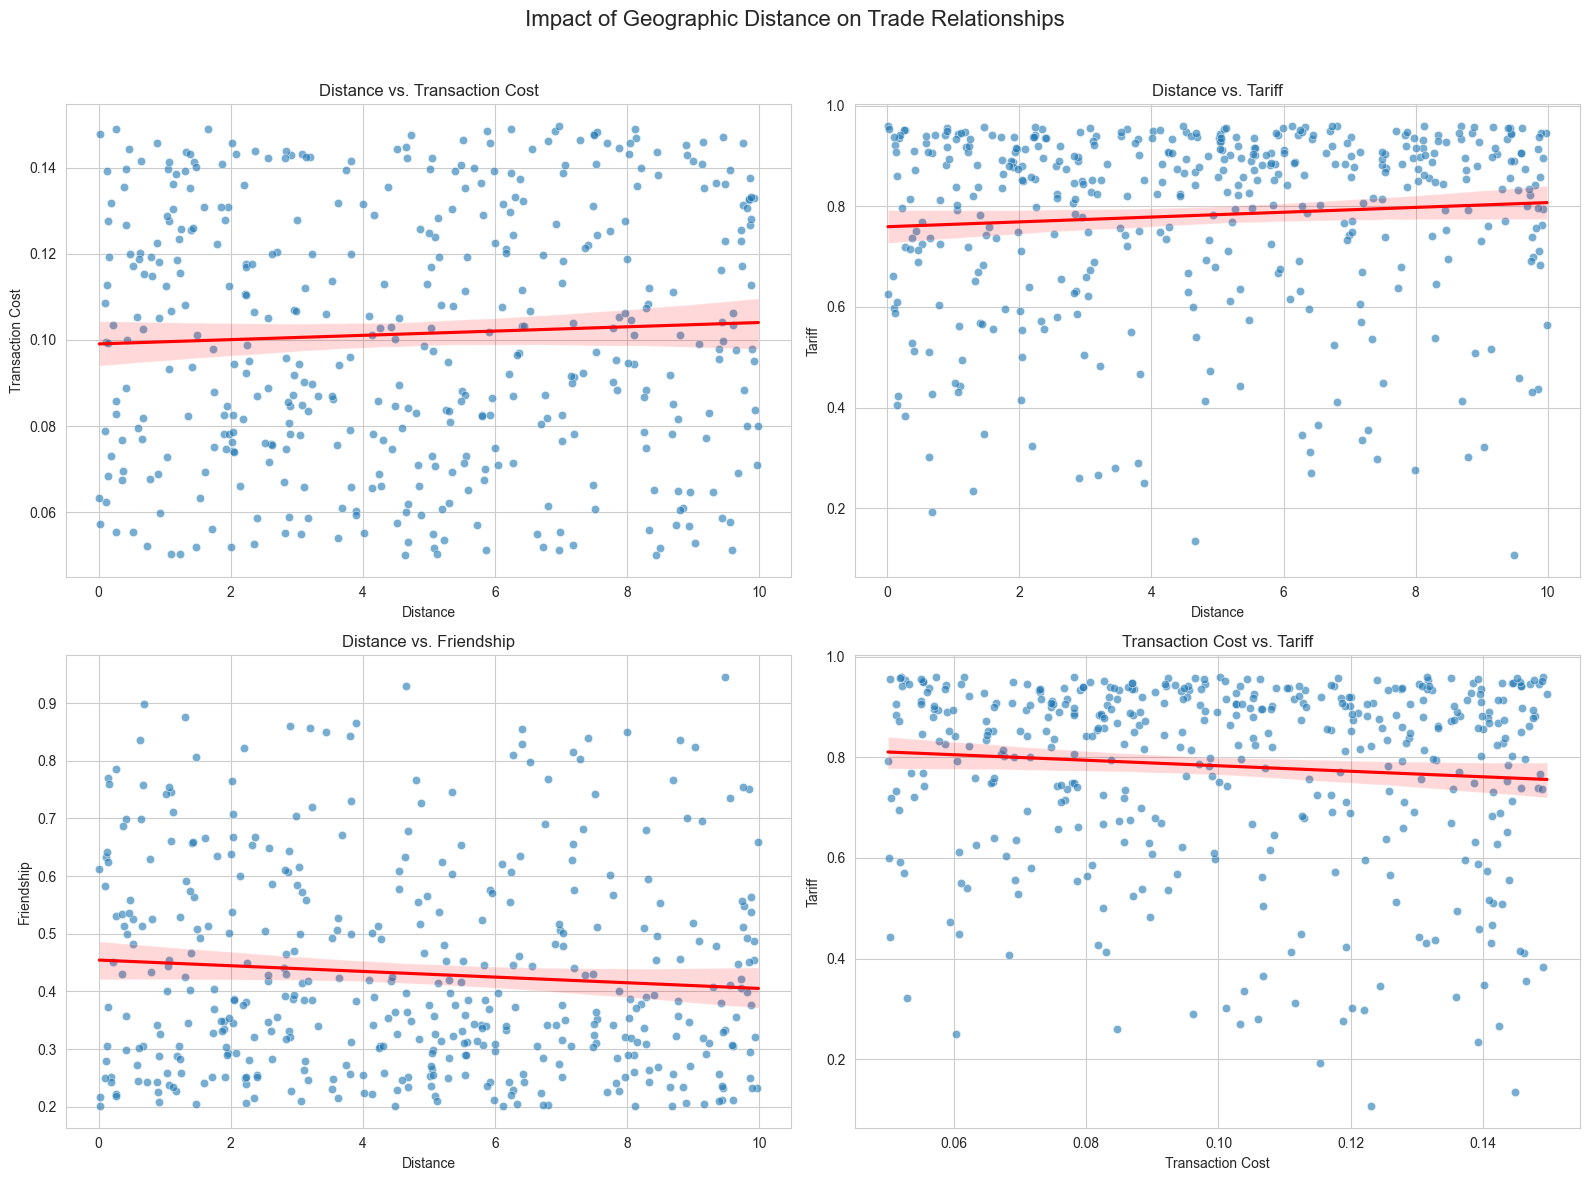

Correlation Analysis:
                  Distance  Transaction Cost  Tariff  Friendship
Distance            1.0000            0.0500  0.0782     -0.0819
Transaction Cost    0.0500            1.0000 -0.0888      0.0752
Tariff              0.0782           -0.0888  1.0000     -0.9834
Friendship         -0.0819            0.0752 -0.9834      1.0000

Transaction Costs by Distance Quartile:
                   Transaction Cost  Tariff  Friendship
Distance Quartile                                      
Q1 (Closest)                 0.1031  0.7533      0.4600
Q2                           0.0957  0.7773      0.4352
Q3                           0.1005  0.8048      0.4099
Q4 (Farthest)                0.1065  0.7937      0.4179


/var/folders/cd/vmj840453cz603ygrc6my4300000gn/T/ipykernel_62403/471213971.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_stats = df.groupby('Distance Quartile').agg({


In [10]:
analyze_distance_effect()

## Trade Communities and Blocs Analysis

In the global trade network, countries often form natural trading communities or blocs based on their relationships. These communities may represent regional trade agreements, cultural similarities, or strategic alliances.

Below, we use community detection algorithms to identify these natural trading communities in our simulated network. This analysis can reveal:

- The number of distinct trading blocs
- The size and influence of each community
- The overall modularity of the network (how well-defined the communities are)

In [11]:
def visualize_communities():
    if G.number_of_edges() > 0:
        G_undir = G.to_undirected()

        try:
            # Calculate node positions with a more stable layout
            pos = nx.spring_layout(G_undir, seed=42, k=0.2, iterations=100)

            # Method 1: Louvain community detection if available
            try:
                from community import community_louvain
            except ImportError:
                raise ImportError("community_louvain module not available")

            # Detect communities
            partition = community_louvain.best_partition(G_undir)

            # Prepare figure
            plt.figure(figsize=(14, 10))

            # Count communities
            communities = set(partition.values())
            num_communities = len(communities)

            # Color nodes by community
            cmap = plt.cm.get_cmap('viridis', num_communities)

            # Draw nodes colored by community
            for com in communities:
                com_nodes = [node for node in partition if partition[node] == com]
                nx.draw_networkx_nodes(
                    G_undir, pos, com_nodes,
                    node_size=40,
                    node_color=[cmap(com)] * len(com_nodes),
                    label=f"Community {com}"
                )

            nx.draw_networkx_edges(G_undir, pos, alpha=0.2, width=0.5)
            plt.title(f"Trade Network Communities (Louvain Method) - {num_communities} communities detected")
            plt.axis('off')
            plt.legend(scatterpoints=1, frameon=True, labelspacing=1, fontsize=8, loc='upper right')
            plt.tight_layout()
            plt.show()

            # Community statistics
            community_sizes = {}
            for com in communities:
                size = sum(1 for node in partition if partition[node] == com)
                community_sizes[f"Community {com}"] = size

            sizes_df = pd.DataFrame(list(community_sizes.items()), columns=['Community', 'Size'])
            sizes_df = sizes_df.sort_values('Size', ascending=False).reset_index(drop=True)

            plt.figure(figsize=(12, 6))
            ax = sns.barplot(x='Community', y='Size', data=sizes_df.head(15))
            plt.title('Top 15 Community Sizes')
            plt.xticks(rotation=45)

            for i, p in enumerate(ax.patches):
                if i < len(sizes_df.head(15)):
                    ax.annotate(
                        str(int(p.get_height())),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom'
                    )

            plt.tight_layout()
            plt.show()

            print(f"Detected {num_communities} communities in the trade network.")
            print(f"Modularity of the partition: {community_louvain.modularity(partition, G_undir):.4f}")
            print(f"Largest community size: {sizes_df['Size'].max()} countries")
            print(f"Smallest community size: {sizes_df['Size'].min()} countries")

        except (NameError, ImportError):
            print("Louvain community detection not available, using alternative method...")
            from networkx.algorithms.community import greedy_modularity_communities
            fallback_communities = list(greedy_modularity_communities(G_undir))
            print(f"Detected {len(fallback_communities)} communities using a greedy modularity approach.")
    else:
        print("No edges remain in the network.")

/var/folders/cd/vmj840453cz603ygrc6my4300000gn/T/ipykernel_62403/3885934602.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', num_communities)


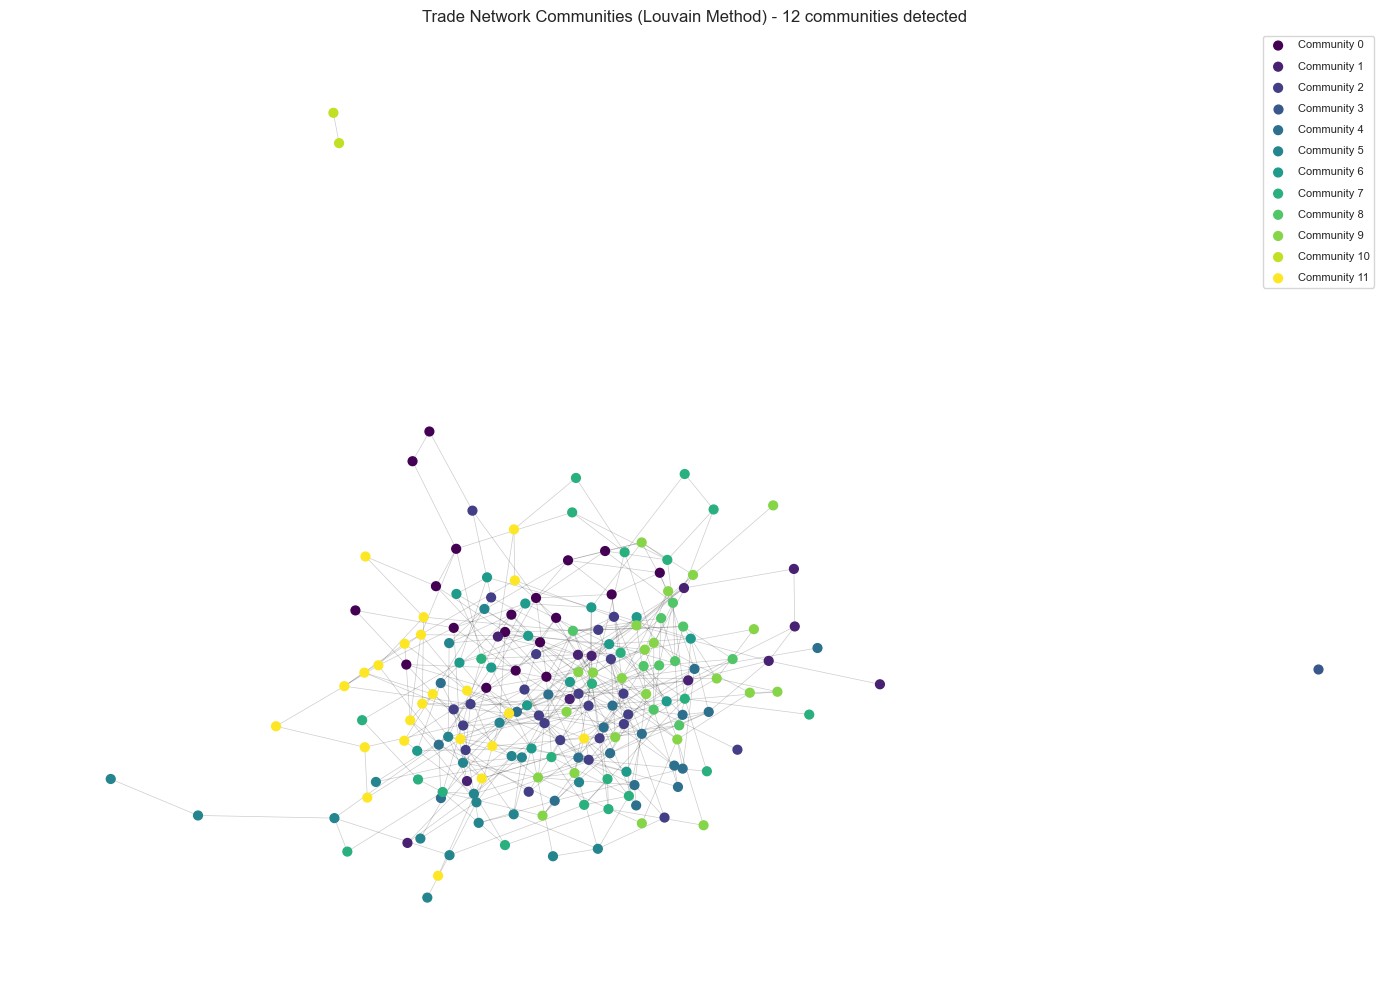

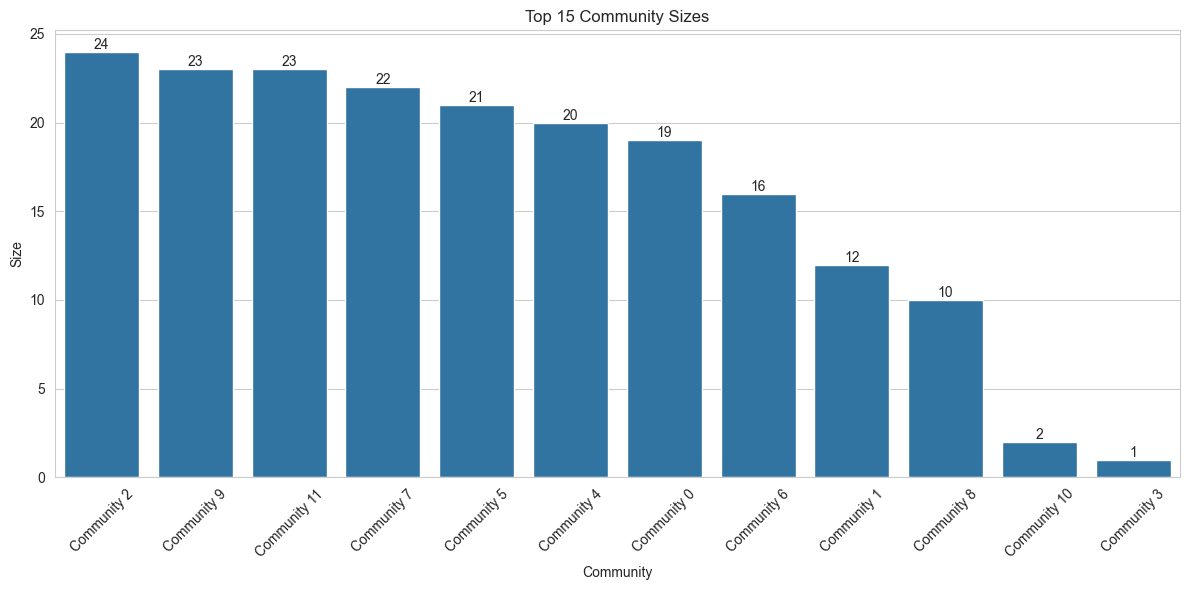

Detected 12 communities in the trade network.
Modularity of the partition: 0.4554
Largest community size: 24 countries
Smallest community size: 1 countries


In [12]:
visualize_communities()